In [1]:
# we are using stellergraph and this implementation follows their example: 
# https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html

In [2]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [3]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, _ = dataset.load()

In [4]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 4433 positive and 4433 negative edges. **


In [5]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 3990 positive and 3990 negative edges. **


In [6]:
print(G_train.info())
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 35915

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [35915]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 39905

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [39905]
        Weights: all 1 (default)
        Features: none


In [7]:
batch_size = 20
epochs = 20
num_samples = [20, 10] # 1hop, 2hop samples

In [8]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [9]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [10]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [11]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

In [12]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [13]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

c:\ProgramData\Miniconda3\envs\gcn\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# evaluate untrained
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

444/444 [==============================] - 22s 50ms/step - loss: 0.8548 - acc: 0.6882

Train Set Metrics of the initial (untrained) model:
	loss: 0.8705
	acc: 0.6881

Test Set Metrics of the initial (untrained) model:
	loss: 0.8548
	acc: 0.6882


In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
# train the model 
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
399/399 - 42s - loss: 0.5221 - acc: 0.7516 - val_loss: 0.4147 - val_acc: 0.7964 - 42s/epoch - 106ms/step
Epoch 2/20
399/399 - 41s - loss: 0.4016 - acc: 0.8343 - val_loss: 0.3592 - val_acc: 0.8480 - 41s/epoch - 102ms/step
Epoch 3/20
399/399 - 41s - loss: 0.3613 - acc: 0.8575 - val_loss: 0.3520 - val_acc: 0.8572 - 41s/epoch - 102ms/step
Epoch 4/20
399/399 - 42s - loss: 0.3419 - acc: 0.8741 - val_loss: 0.3417 - val_acc: 0.8670 - 42s/epoch - 106ms/step
Epoch 5/20
399/399 - 40s - loss: 0.3098 - acc: 0.8883 - val_loss: 0.3320 - val_acc: 0.8715 - 40s/epoch - 100ms/step
Epoch 6/20
399/399 - 41s - loss: 0.3069 - acc: 0.8937 - val_loss: 0.3372 - val_acc: 0.8709 - 41s/epoch - 103ms/step
Epoch 7/20
399/399 - 42s - loss: 0.2762 - acc: 0.9039 - val_loss: 0.3158 - val_acc: 0.8711 - 42s/epoch - 105ms/step
Epoch 8/20
399/399 - 41s - loss: 0.2665 - acc: 0.9038 - val_loss: 0.3251 - val_acc: 0.8764 - 41s/epoch - 103ms/step
Epoch 9/20
399/399 - 40s - loss: 0.2453 - acc: 0.9165 - val_loss: 0.3324

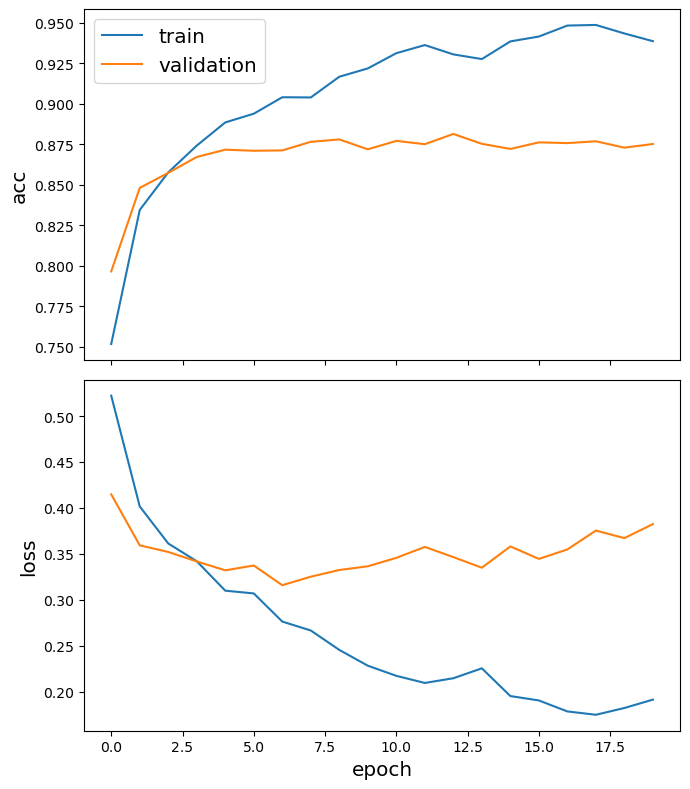

In [17]:
sg.utils.plot_history(history)

In [18]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

444/444 [==============================] - 22s 50ms/step - loss: 0.3797 - acc: 0.8728

Train Set Metrics of the trained model:
	loss: 0.1411
	acc: 0.9617

Test Set Metrics of the trained model:
	loss: 0.3797
	acc: 0.8728


## Repeat for PubMed dataset 